In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
fileName = "/content/casefile_v1_UTTAR_PRADESH_2023_24_UP_Secondary_Total_rural_merged.csv"

In [3]:
try:
    df = pd.read_csv(fileName)
except FileNotFoundError:
    print(f"Error: File not found at {fileName}. Please ensure the path is correct.")

In [4]:
df

,"Men Age Group 15 Years And Above Who Use Any Kind Of Tobacco (%) (UOM:%(Percentage)), Scaling Factor:1",%comp_lab_cond_not_equipped,"Women Age Group 20 To 24 Years Married Before Age 18 Years (%) (UOM:%(Percentage)), Scaling Factor:1",%electricity_availability_no,%boundary_wall_pucca,%tap_fun_yn_yes,"Households Using Clean Fuel For Cooking (%) (UOM:%(Percentage)), Scaling Factor:1",smart_class_tv_tot(avg),urinal_girls(avg),"Population Living In Households With Electricity (%) (UOM:%(Percentage)), Scaling Factor:1",regular_avg,"Population Living In Households That Use An Improved Sanitation Facility (%) (UOM:%(Percentage)), Scaling Factor:1",%comp_lab_cond_equipped,%medium_instr1_english,classrooms_in_good_condition(avg),class_taught_upr_sec_avg,%comp_ict_lab_yn_yes,bed_equivalent_avg,MPI NFHS 5,dropout_rate
0,46.1,55.840456,17.9,8.012151,87.583064,32.846022,67.5,0.318018,1.609645,99.1,5.448073,70.8,44.159544,8.828555,7.123410,0.421302,14.733245,3.513385,0.080,2.6
1,37.0,64.951768,15.8,18.610366,90.102770,56.344951,51.4,0.158400,1.528820,95.3,4.895442,69.4,35.048232,8.243968,6.643878,0.303396,8.042895,3.018097,0.095,13.5
2,52.9,60.955056,5.5,14.594011,76.449960,63.285676,32.2,0.145131,1.420286,94.2,5.071217,63.6,39.044944,5.341246,6.776369,0.088211,7.364446,3.060966,0.085,10.2
3,49.3,70.731707,14.9,15.805825,69.786408,54.135922,26.4,0.107573,1.342913,92.3,3.810097,60.9,29.268293,6.834951,5.350680,0.113786,6.912621,1.940583,0.131,11.1
4,46.8,68.055556,18.1,18.273005,78.368949,39.729612,33.7,0.125600,1.322285,94.0,4.312691,74.3,31.944444,3.794156,5.061491,0.167030,8.547754,2.826428,0.084,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,59.7,64.024390,20.8,22.399433,79.000532,48.272196,31.5,0.089669,1.271487,68.4,4.160907,52.5,35.975610,2.498671,4.709374,0.145136,5.599858,2.102073,0.189,12.9
71,54.1,46.308725,17.7,22.563370,71.295966,42.520528,30.4,0.248483,1.409497,82.9,3.406283,70.6,53.691275,5.390932,4.936808,0.127454,11.353088,1.812924,0.141,13.3
72,47.5,59.479554,7.9,14.169472,72.839506,49.803591,33.7,0.138328,1.420034,94.3,4.895062,65.1,40.520446,3.619529,5.900954,0.154882,8.726150,2.975870,0.093,7.0
73,50.9,60.750853,18.9,17.849989,79.367906,47.985756,43.4,0.054974,1.239929,75.4,4.110839,60.3,39.249147,2.960160,4.567772,0.113732,5.675495,2.144447,0.107,12.4


In [5]:
# indicator = "dropout_rate"
# factors = [col for col in df.columns if col not in [indicator]]
indicator = ["dropout_rate", "MPI NFHS 5"]
factors = [col for col in df.columns if col not in indicator]
num_samples, num_factors = df.shape[0], len(factors)

In [6]:
corr = df.corr(method="pearson")

In [7]:
THRESHOLD = 0.395
# THRESHOLD = 0.6
number_of_states = num_samples

In [8]:
# type(factors)

In [9]:
G = nx.Graph()
G.add_nodes_from(factors, type="factor")
# G.add_node(indicator, type="outcome")
G.add_nodes_from(indicator, type="outcome")

In [10]:
for i in factors:
    for j in factors:
        if i != j:
            r = corr.loc[i, j]
            if pd.notna(r) and abs(r) >= THRESHOLD:
                G.add_edge(i, j, weight=r)

# for f in factors:
#     r = corr.loc[f, indicator]
#     if pd.notna(r) and abs(r) >= THRESHOLD:
#         G.add_edge(f, indicator, weight=r)

for f in factors:
    for ind in indicator:
        r = corr.loc[f, ind]
        if pd.notna(r) and abs(r) >= THRESHOLD:
            G.add_edge(f, ind, weight=r)

# Functions, like sigmoid, forwards pass, etc.

In [11]:
# look for inverse sigmoid
def sigmoid(x):
    mask = x >= 0
    positive_sig = 1 / (1 + np.exp(-x[mask]))
    negative_sig = np.exp(x[~mask]) / (np.exp(x[~mask]) + 1)

    result = np.empty_like(x)
    result[mask] = positive_sig
    result[~mask] = negative_sig
    return result

In [12]:
def forward_pass(F, W, B):
    z = F @ W + B
    # return z
    output = sigmoid(z)
    return output

# def forward_pass(F, W, B):
#     n_samples, n_nodes = F.shape
#     F_new = np.zeros((n_samples, n_nodes))
#     for i in range(n_nodes): #19
#         col_sum = np.zeros(n_samples)
#         w_col = W[:, i]
#         for j in range(n_nodes):
#             col_sum += w_col[j] * F[:, j]
#         F_new[:, i] = col_sum + B[:, i]
#     return F_new

In [13]:
def getError(F, F_hat):
    # print(type(F))
    e = np.mean(abs(F - F_hat), axis=0)
    # e = abs(F - F_hat)
    return e

# district errors to get geography wise errors, and bucket reg
# plot district wise error, to see how areas are converging.

# get the error vector of size 75, and have epochs number of such vectors, and use these vectors for plotting the error.

In [14]:
def getError_mahalanobis_stable(F, F_hat, shrink_alpha=0.2, eps_std=1e-6, eps_cov=1e-6):

    mean = F.mean(axis=0)
    std = F.std(axis=0)
    std = np.maximum(std, eps_std)
    F_std = (F - mean) / std
    F_hat_std = (F_hat - mean) / std

    cov = np.cov(F_std, rowvar=False)
    diag_cov = np.diag(np.diag(cov))
    cov = (1 - shrink_alpha) * cov + shrink_alpha * diag_cov
    cov += np.eye(cov.shape[0]) * eps_cov
    inv_cov = np.linalg.pinv(cov)

    diff = F_hat_std - F_std
    weighted = diff @ inv_cov
    contrib = diff * weighted
    e = np.mean(contrib, axis=0)

    e = np.tanh(e)
    return e

In [15]:
def train_step(F, W, B, eta, MASK):
    F_hat = forward_pass(F, W, B)
    e = getError(F, F_hat)
    # print("Hi")
    # for x in e:
    #   print(x)
    # e = getError_mahalanobis_stable(F, F_hat)
    F_avg = np.mean(F, axis=0)
    W = W + eta * e[np.newaxis, :] * F_avg

    # W = W + eta * e[np.newaxis, :]

    np.fill_diagonal(W, 0)
    B = B + eta * e[np.newaxis, :]
    # e =
    return W, B, F_hat, e

In [16]:
# def train_model(Factor_Data, W, B, MASK, eta=0.1, epochs=75):
#     loss_history = []
#     for state in range(epochs):
#         epoch_errors = []
#         F_pass = Factor_Data[state]

#         W, B, F_hat, e = train_step(Factor_Data, W, B, eta, MASK)
#         MAE = np.mean(e)
#         loss_history.append(MAE)
#         if state % 10 == 0 or state == 1:
#             print(f"Epoch {state:03d}/{epochs}: MAE Loss = {MAE:.6f}")
#     return W, B, loss_history

def train_model(Factor_Data, W, B, MASK, eta=0.1, epochs=500):
    loss_history = []
    for epoch in range(epochs):
      error_vector = []
      for state in range(number_of_states):
          # state = state % 75
          epoch_errors = []
          F_pass = Factor_Data[state]
          # n = len(F_pass[0])
          n = 19
          F_pass = np.tile(F_pass, (n, 1))
          # print("Fpass size: ", F_pass.size)
          # print("W size: ", W.size)
          # print("B size: ", B.size)
          W, B, F_hat, e = train_step(F_pass, W, B, eta, MASK)
          MAE = np.mean(e)
          error_vector.append(MAE)
          # loss_history.append(MAE)
      if state % 5 == 0 or state == 1:
          print(f"Epoch {state:03d}/{epochs}: MAE Loss = {MAE:.6f}")
      loss_history.append(error_vector)
    return W, B, loss_history


In [17]:
nodes = factors
A = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
W = np.copy(A)

In [18]:
W = W / (np.abs(W).max() + 1e-8)

W_initial = np.copy(W)
CONNECTION_MASK = (W_initial != 0).astype(int)
np.fill_diagonal(CONNECTION_MASK, 0)

B = np.full(num_factors, 0.02)
B = np.tile(B, (19, 1))
loss_history = []
Factor_Data = df[factors].values
Factor_Data = Factor_Data / Factor_Data.max(axis=0)

In [19]:
Factor_Data[0]

array([0.71472868, 0.7573763 , 0.34489403, 0.25115615, 0.9283474 ,
       0.41765972, 0.73051948, 0.1336074 , 0.44475351, 0.99199199,
       0.44604255, 0.8137931 , 0.59545449, 0.29672808, 0.48837744,
       0.45417187, 0.33486396, 0.41041356])

In [20]:
n_samples, n_nodes = Factor_Data.shape
print(n_nodes)
print(n_samples)

18
75


In [21]:
eta = 0.1
epochs = 20

$$z_i = \sum_{j} w_{ji}F_j + b_i$$

$$\hat{F}_i = \sigma(z_i) = 1/(1 + e^{-z_i})$$

$$e_i = F_i - \hat{F}_i$$

$$\text{Update: } w_{ji} += \eta e_i F_j, \quad b_i += \eta e_i$$

In [22]:
W, B, loss_history = train_model(Factor_Data, W, B, CONNECTION_MASK, eta, epochs)

# So, I made graphs with taking both, F_avg as 1, and its original value. Overall, in both the cases, the error graph does reach zero, its just a question of when. In 1 case, it reaches zero in 100 epochs, in the other is ~150

In [23]:
len(loss_history)

20

In [24]:
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(loss_history) + 1), loss_history, marker='.', linestyle='-', color='darkred')
# plt.title('Training Loss (Mean Absolute Error) Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Mean Absolute Error (MAE)')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.axhline(y=loss_history[0], color='blue', linestyle=':', label=f'Initial MAE ({loss_history[0]:.4f})')
# plt.axhline(y=loss_history[-1], color='green', linestyle=':', label=f'Final MAE ({loss_history[-1]:.4f})')
# plt.legend()
# plt.show()

In [25]:
import geopandas as gpd
import imageio
import matplotlib.cm as cm

In [26]:
num_districts = len(loss_history[0])
epochs = len(loss_history)

In [27]:
up_map = gpd.read_file("/content/uttar-pradesh.kml", driver="KML")

In [28]:
district_names_in_order = list(up_map["Name"])

In [29]:
cmap = cm.get_cmap("plasma", 1024)

/tmp/ipython-input-4005952688.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", 1024)


In [30]:
# num_districts = len(loss_history[0])
# epochs = len(loss_history)

# up_map = gpd.read_file("/content/uttar-pradesh.kml", driver="KML")

# frames = []

# district_names_in_order = list(up_map["Name"])
# cmap = cm.get_cmap("plasma", 1024)

# for epoch in range(epochs):

#     # Add loss column for current epoch
#     up_map["loss"] = loss_history[epoch]

#     # Epoch-wise normalization
#     vmin = up_map["loss"].min()
#     vmax = up_map["loss"].max()

#     fig, ax = plt.subplots(figsize=(6, 8), dpi=120)

#     plt.tight_layout(pad=0)

#     up_map.plot(
#         column="loss",
#         cmap=cmap,
#         vmin=vmin,
#         vmax=vmax,
#         linewidth=0.4,
#         edgecolor="black",
#         ax=ax,
#         legend=True
#     )

#     ax.set_title(f"UP District Loss Heatmap - Epoch {epoch + 1}", fontsize=14)
#     ax.set_axis_off()

#     frame_path = f"/content/frames/epoch_{epoch+1}.png"
#     fig.savefig(frame_path, bbox_inches="tight", pad_inches=0, dpi=120)
#     plt.close(fig)

#     frames.append(imageio.imread(frame_path))

In [31]:
# imageio.mimsave("/content/up_loss_heatmap.gif", frames, duration=1)

In [32]:
# frames = []
# transition_frames = 10   # smoothness

# for epoch in range(epochs - 1):

#     # Correct: convert to array
#     start = np.array(loss_history[epoch], dtype=float)
#     end   = np.array(loss_history[epoch + 1], dtype=float)

#     # Compute global min/max for stable color scale
#     vmin = min(start.min(), end.min())
#     vmax = max(start.max(), end.max())

#     # Use modern matplotlib colormap API
#     cmap = cm.get_cmap("plasma")

#     # Generate transition frames
#     for t in range(transition_frames):
#         alpha = t / transition_frames
#         interpolated_loss = (1 - alpha) * start + alpha * end

#         up_map["loss"] = interpolated_loss

#         fig, ax = plt.subplots(1, 1, figsize=(8, 10))
#         up_map.plot(
#             column="loss",
#             cmap=cmap,
#             vmin=vmin,
#             vmax=vmax,
#             linewidth=0.5,
#             edgecolor="black",
#             ax=ax,
#             legend=False,
#         )
#         ax.set_title(f"UP District Loss Heatmap (Epoch {epoch + alpha:.2f})", fontsize=15)
#         ax.axis("off")

#         # Save temporary PNG
#         frame_path = f"/content/frames/frame_{epoch}_{t}.png"
#         plt.savefig(frame_path, dpi=120, bbox_inches="tight")
#         plt.close()

#         frames.append(imageio.imread(frame_path))


In [33]:
# frames = []
# transition_frames = 10   # smoothness

# for epoch in range(epochs - 1):

#     # Convert to array for interpolation
#     start = np.array(loss_history[epoch], dtype=float)
#     end   = np.array(loss_history[epoch + 1], dtype=float)

#     # Compute global min/max for stable color scale
#     vmin = min(start.min(), end.min())
#     vmax = max(start.max(), end.max())

#     # Use modern matplotlib colormap API
#     cmap = cm.get_cmap("plasma")

#     # Generate transition frames
#     for t in range(transition_frames):
#         alpha = t / transition_frames
#         interpolated_loss = (1 - alpha) * start + alpha * end

#         up_map["loss"] = interpolated_loss

#         fig, ax = plt.subplots(1, 1, figsize=(8, 10))

#         # Plot base map
#         plot = up_map.plot(
#             column="loss",
#             cmap=cmap,
#             vmin=vmin,
#             vmax=vmax,
#             linewidth=0.5,
#             edgecolor="black",
#             ax=ax,
#             legend=False   # We create our own colorbar below
#         )

#         ax.set_title(f"UP District Loss Heatmap (Epoch {epoch + alpha:.2f})", fontsize=15)
#         ax.axis("off")

#         # ADD COLORBAR (label + ticks)
#         sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#         sm._A = []  # Required for older Matplotlib versions
#         cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
#         cbar.set_label("Loss Value", fontsize=12)

#         # Save temporary PNG
#         frame_path = f"/content/frames/frame_{epoch}_{t}.png"
#         plt.savefig(frame_path, dpi=120, bbox_inches="tight")
#         plt.close()

#         frames.append(imageio.imread(frame_path))


In [34]:
# frames = []
# # for making the transition look easier
# transition_frames = 10

# for epoch in range(epochs - 1):

#     start = np.array(loss_history[epoch], dtype=float)
#     end   = np.array(loss_history[epoch + 1], dtype=float)

#     vmin = min(start.min(), end.min())
#     vmax = max(start.max(), end.max())

#     cmap = cm.get_cmap("plasma")

#     for t in range(transition_frames):
#         alpha = t / transition_frames
#         interpolated_loss = (1 - alpha) * start + alpha * end

#         up_map["loss"] = interpolated_loss

#         fig, ax = plt.subplots(1, 1, figsize=(8, 10))
#         fig.set_tight_layout(False)

#         plot = up_map.plot(
#             column="loss",
#             cmap=cmap,
#             vmin=vmin,
#             vmax=vmax,
#             linewidth=0.5,
#             edgecolor="black",
#             ax=ax,
#             legend=False
#         )

#         ax.set_title(f"UP District Loss Heatmap (Epoch {epoch + alpha:.2f})", fontsize=15)
#         ax.axis("off")

#         sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#         sm._A = []
#         cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
#         cbar.set_label("Loss Value", fontsize=12)

#         plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)

#         frame_path = f"/content/frames/frame_{epoch}_{t}.png"
#         plt.savefig(frame_path, dpi=120)
#         plt.close()

#         frames.append(imageio.imread(frame_path))


In [35]:
# imageio.mimsave("/content/up_loss_smoothFINAL5T06.gif", frames, fps=5)

In [36]:
loss_history

[[np.float64(0.3900745819606557),
  np.float64(0.4367380361286347),
  np.float64(0.45877730285362184),
  np.float64(0.4363388285632959),
  np.float64(0.43708643054147756),
  np.float64(0.42386301329886344),
  np.float64(0.34470111492762107),
  np.float64(0.4363202160642523),
  np.float64(0.43261434065946),
  np.float64(0.43258355143968347),
  np.float64(0.463960660594188),
  np.float64(0.421724926038546),
  np.float64(0.36957719531614064),
  np.float64(0.4586916176887564),
  np.float64(0.4051331288736154),
  np.float64(0.4190361612051137),
  np.float64(0.43877210300380365),
  np.float64(0.3937741497899087),
  np.float64(0.4143665308477176),
  np.float64(0.4816162205511528),
  np.float64(0.4214291108403192),
  np.float64(0.45355005701580686),
  np.float64(0.4529139701749576),
  np.float64(0.45042864643845804),
  np.float64(0.4594284169891143),
  np.float64(0.49487801914524454),
  np.float64(0.4730819823077582),
  np.float64(0.1287795954307672),
  np.float64(0.23808395260481033),
  np.fl

In [37]:
frames = []
transition_frames = 10
for epoch in range(epochs - 1):

    start = np.array(loss_history[epoch], dtype=float)
    end   = np.array(loss_history[epoch + 1], dtype=float)

    vmin = min(start.min(), end.min())
    vmax = max(start.max(), end.max())

    cmap = cm.get_cmap("plasma")

    for t in range(transition_frames):
        alpha = t / transition_frames
        interpolated_loss = (1 - alpha) * start + alpha * end

        up_map["loss"] = interpolated_loss

        fig, ax = plt.subplots(1, 1, figsize=(8, 10))
        fig.set_tight_layout(False)

        plot = up_map.plot(
            column="loss",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            linewidth=0.5,
            edgecolor="black",
            ax=ax,
            legend=False
        )

        for i, name in enumerate(district_names_in_order):
            geom = up_map.loc[i, "geometry"]
            if geom.geom_type == "MultiPolygon":
                centroid = max(geom.geoms, key=lambda g: g.area).centroid
            else:
                centroid = geom.centroid
            ax.text(
                centroid.x,
                centroid.y,
                name,
                fontsize=7,
                ha="center",
                va="center",
                color="black",
                weight="bold"
            )

        ax.set_title(f"UP District Loss Heatmap (Epoch {epoch + alpha:.2f})", fontsize=15)
        ax.axis("off")

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label("Loss Value", fontsize=12)

        plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)

        frame_path = f"/content/frames/frame_{epoch}_{t}.png"
        plt.savefig(frame_path, dpi=120)
        plt.close()

        frames.append(imageio.imread(frame_path))


/tmp/ipython-input-2513522917.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")
/tmp/ipython-input-2513522917.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))
/tmp/ipython-input-2513522917.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))
/tmp/ipython-input-2513522917.py:64: DeprecationWa

In [38]:
imageio.mimsave("/content/up_loss_smoothFINAL5LabelT06.gif", frames, fps=5)

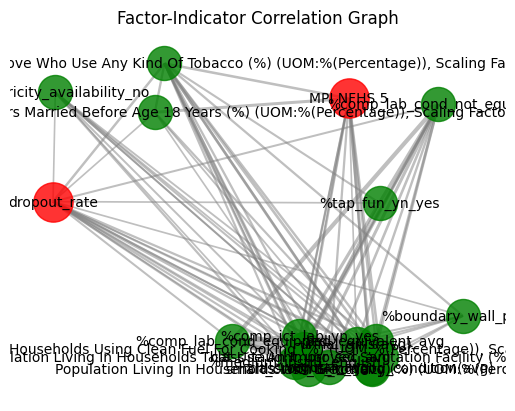

In [39]:

pos = nx.spring_layout(G, seed=42)
factor_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "factor"]
indicator_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "outcome"]
nx.draw_networkx_nodes(G, pos, nodelist=factor_nodes, node_color="green", node_size=600, alpha=0.8)
nx.draw_networkx_nodes(G, pos, nodelist=indicator_nodes, node_color="red", node_size=800, alpha=0.8)

edges = G.edges(data=True)
weights = [abs(d["weight"])*3 for (u,v,d) in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.5, edge_color="gray")

nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

plt.title("Factor-Indicator Correlation Graph")
plt.axis("off")
plt.show()